[En français](../use-case-oafeat-en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python

# Use case: Tracking water level with GeoMet-OGC-API

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON file can than be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with [Python](https://www.python.org/)
* Display the retrieved data on a web map
* Analyse the data and display the results in graphic and tabular format
* Export the data in a format of your choice

An [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=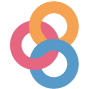)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

## Creation of a tool to track water level 

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water level of a few hydrometric stations near her city to guide the management of the company activities. She would like to have:
* An overview of the distribution of the daily water level of the past 3 months for all hydrometric stations located within 100 km of the city of Chilliwack (minimum, first quartile, median, third quartile and maximum) 
* A graphic view that presents the provisional daily mean water level of the past 3 months with a color code to indicate the water level status
* A tabular view that shows the provisional daily mean water level of the past 3 months with the same color code
* A web map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations with the appropriate color code
* The provisional daily mean water level of the past 3 months in a WaterML2.0 format for exportation

To achieve this, the first step is to retrieve the water level data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with Python.

In [1]:
# Module importation
from datetime import date

from dateutil.relativedelta import relativedelta
from owslib.ogcapi.features import Features
from osgeo import ogr, osr
import pandas as pd

In [2]:
# Parameters

# Coordinates
lat = 49.162676
long = -121.958943

# Buffer size in kilometer
buffer = 100

# Number of months used to analyse historical data
numMonths = 3

# Prefered projection
# NAD83 / Statistics Canada Lambert
projection = 3347 

In [3]:
# Generating parameters for the OGC API - Features request

# Bounding box a little bigger than buffer size (1 km ≈ 0.01°)
bbox = [str(long-(buffer/2)*0.01),
        str(lat-(buffer/2)*0.01),
        str(long+(buffer/2)*0.01),
        str(lat+(buffer/2)*0.01)
       ]

# Time
endDate = date.today()
endDate = date(2012, 7, 20) # Available data to test the code, will not be in final use case
startDate = endDate - relativedelta(months=numMonths)
deltaTime = (endDate - startDate).days
startDate = startDate.strftime("%Y-%m-%d")
time = f'{startDate}/{endDate}'

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features('https://geo.weather.gc.ca/geomet/features')
stationData = oafeat.collection_items('hydrometric-stations', 
                                      bbox=bbox, 
                                      STATUS_EN='Active')

In [5]:
# Generating a list of stations inside the buffer zone

# Set the driver
driver = ogr.GetDriverByName('GeoJSON')

# Create a datasource and get the layer
stationData = str(stationData).replace("'", '"').replace("None", "null")
dataSource = driver.Open(stationData, 0) # 0 means read-only. 1 means writeable.
layer = dataSource.GetLayer()

# Identify input spatial reference system
srsInput = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srsInput))
epsg = sr.GetAuthorityCode(None)
srsInput.ImportFromEPSG(int(epsg))

# Spatial reference system used to project data
srsProjected = osr.SpatialReference()
srsProjected.ImportFromEPSG(projection)

# Transformation from input srs to NAD83 / Statistics Canada Lambert
transform = osr.CoordinateTransformation(srsInput, srsProjected)

# Create a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
pointBuffer = point.Buffer(buffer*1000) # The value must be in meters

# Select the stations in the buffer zone
stations = []
for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(pointBuffer):
        stations.append(feature.GetField('STATION_NUMBER'))

In [6]:
# Temporary prints, will not be in the final use case
print(len(stations))
print(stations)

18
['08MF005', '08MF035', '08MF072', '08MF073', '08MG001', '08MG012', '08MG013', '08MG014', '08MG022', '08MH001', '08MH016', '08MH024', '08MH029', '08MH056', '08MH103', '08MH147', '08MH153', '08MH167']


In [10]:
# Retrieval of hydrometric data for each station

toRemove = []
# Dictionary that will contain a data frame for each station 
waterLevel = {}
# Retrieval of the data and creation of the data frames
for station in stations:
    hydroData = oafeat.collection_items(
        'hydrometric-daily-mean',
        bbox=bbox,
        time=time,
        STATION_NUMBER=station
    )
    dates = []
    levelValues = []
    for feature in hydroData['features']:
        dates.append(feature['properties']['DATE'])
        levelValues.append(feature['properties']['LEVEL'])
    if (len(levelValues) == deltaTime + 1 and 
            not all(val is None for val in levelValues) and
            levelValues[-1] is not None):
        waterLevelData = {'Daily mean': levelValues}
        dfWaterLevel = pd.DataFrame(waterLevelData, index=dates, columns=['Daily mean'])
        waterLevel[station] = dfWaterLevel
    else:
        toRemove.append(station)
        print('removed ' + str(station))
        
for station in toRemove:
    stations.remove(station)

removed 08MH153


In [11]:
# Temporary prints, will not be in the final use case
print(len(stations))
print(stations)

15
['08MF005', '08MF035', '08MF072', '08MF073', '08MG001', '08MG012', '08MG022', '08MH001', '08MH016', '08MH024', '08MH029', '08MH056', '08MH103', '08MH147', '08MH167']


In [70]:
# Creation of interactive plots
from ipywidgets import interact

pd.options.plotting.backend = 'plotly'
    

def chooseStation(station):
    if [waterLevel[station].iloc[-1][0]] < waterLevel[station].quantile(0.25)[0]:
        currentColor = 'limegreen'
    elif [waterLevel[station].iloc[-1][0]] > waterLevel[station].quantile(0.75)[0]:
        currentColor = 'red'
    else:
        currentColor = 'cornflowerblue'
    
    # Creation of the plot
    fig = waterLevel[station].plot(
        title='Water level at station {}'.format(station), 
        template='plotly_white',
        labels=dict(index='Date',
                    value='Water level (m)',
                    variable='Variable'),
        color_discrete_sequence=['gray']
    ).add_scatter(
        y=[float(waterLevel[station].max())] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='Historical max',
        line=dict(color='red', 
                  dash='dash'),
        legendgroup='General legend'
    ).add_scatter(
        y=[float(waterLevel[station].min())] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='Historical min',
        line=dict(color='limegreen', 
                  dash='dash',
                 ),
        legendgroup='General legend'
    ).add_scatter(
        y=[waterLevel[station].iloc[-1][0]] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='High level',
        line=dict(color='red'),
        legendgroup='Current value legend',
        hoverinfo='skip'
    ).add_scatter(
        y=[waterLevel[station].iloc[-1][0]] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='Medium level',
        line=dict(color='cornflowerblue'),
        legendgroup='Current value legend',
        hoverinfo='skip'
    ).add_scatter(
        y=[waterLevel[station].iloc[-1][0]] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='Low level',
        line=dict(color='limegreen'),
        legendgroup='Current value legend',
        hoverinfo='skip'
    ).add_scatter(
        y=[waterLevel[station].iloc[-1][0]] * len(waterLevel[station].index),
        x=waterLevel[station].index, 
        mode='lines',
        name='Current value',
        line=dict(color=currentColor),
        showlegend=False
    )
    fig.update_traces(legendgroup='General legend',
              selector=dict(name='Daily mean'))
    # Updating some plot parameters
    fig.update_traces(hovertemplate=None)
    fig.update_layout(hovermode='x unified', 
                      legend_title='Legend',
                      legend_tracegroupgap=25)
    fig.update_layout(yaxis=dict(range=[float(waterLevel[station].min() - 0.1),
                                        float(waterLevel[station].max() + 0.1)]))
    # fig.update_xaxes(tickformat="%Y-%m-%d")
    fig.add_annotation(
                text='Current value',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.138,
                y=0.76,
            )
    fig.show()
    # fig.show('png')
    
    
dropdown = interact(chooseStation, station=stations)

interactive(children=(Dropdown(description='station', options=('08MF005', '08MF035', '08MF072', '08MF073', '08…